In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [23]:
# Function to load and initially prepare data
def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t')
    data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')
    data['review_body'] = data['review_body'].astype(str)
    data['sentiment'] = data['review_body'].apply(lambda x: TextBlob(x).sentiment.polarity)
    return data

In [24]:
microwave_data = load_data('microwave.tsv')
hair_dryer_data = load_data('hair_dryer.tsv')
pacifier_data = load_data('pacifier.tsv')

In [25]:
# Function to aggregate data
def prepare_data(data):
    # Ensure the datetime conversion and calculation of sentiment have been done
    data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')
    data['review_body'] = data['review_body'].astype(str)
    data['sentiment'] = data['review_body'].apply(lambda x: TextBlob(x).sentiment.polarity)
    grouped_data = data.groupby(data['review_date'].dt.to_period('M')).agg(
        review_count=('review_id', 'count'),
        average_rating=('star_rating', 'mean'),
        average_sentiment=('sentiment', 'mean')
    ).reset_index()
    grouped_data['review_date'] = grouped_data['review_date'].dt.to_timestamp()
    return grouped_data

In [26]:
microwave_data = prepare_data(microwave_data)
hair_dryer_data = prepare_data(hair_dryer_data)
pacifier_data = prepare_data(pacifier_data)

In [6]:
microwave_data.head()

,review_date,review_count,average_rating,average_sentiment
0,2004-06-01,3,4.000000,0.098707
1,2004-07-01,1,3.000000,-0.016250
2,2004-09-01,3,1.333333,0.065013
3,2004-11-01,2,3.000000,0.218090
4,2004-12-01,1,3.000000,0.179090


In [7]:
# Function to analyze trends
def analyze_trends(grouped_data, title):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Review Count', color='tab:blue')
    ax1.plot(grouped_data['review_date'], grouped_data['review_count'], color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average Rating', color='tab:red')
    ax2.plot(grouped_data['review_date'], grouped_data['average_rating'], color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Average Sentiment', color='tab:green')
    ax3.plot(grouped_data['review_date'], grouped_data['average_sentiment'], color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')

    plt.title(f'Review Count, Average Rating, and Sentiment Trends for {title}')
    plt.show()

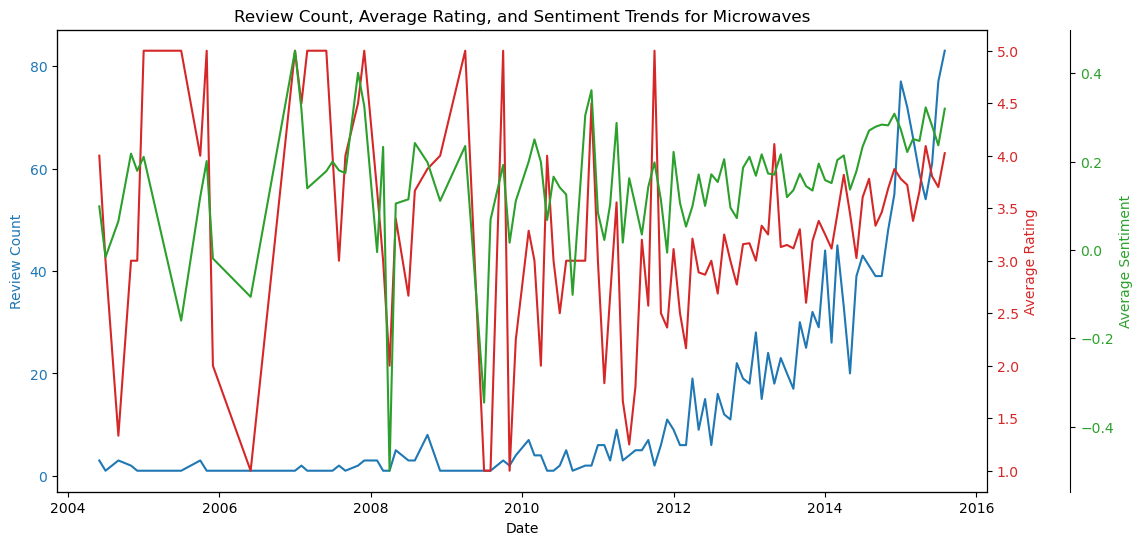

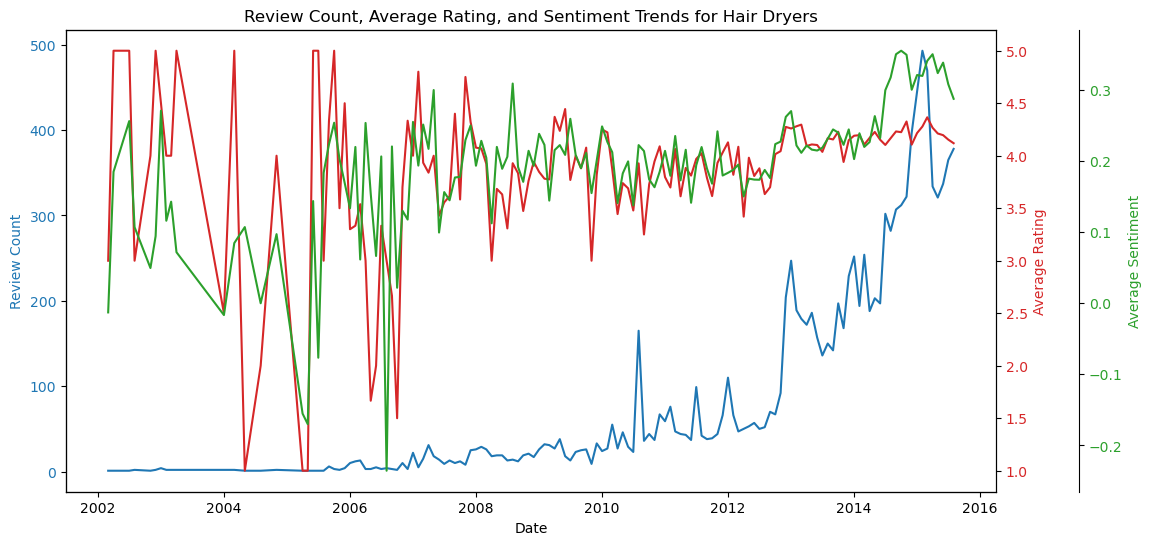

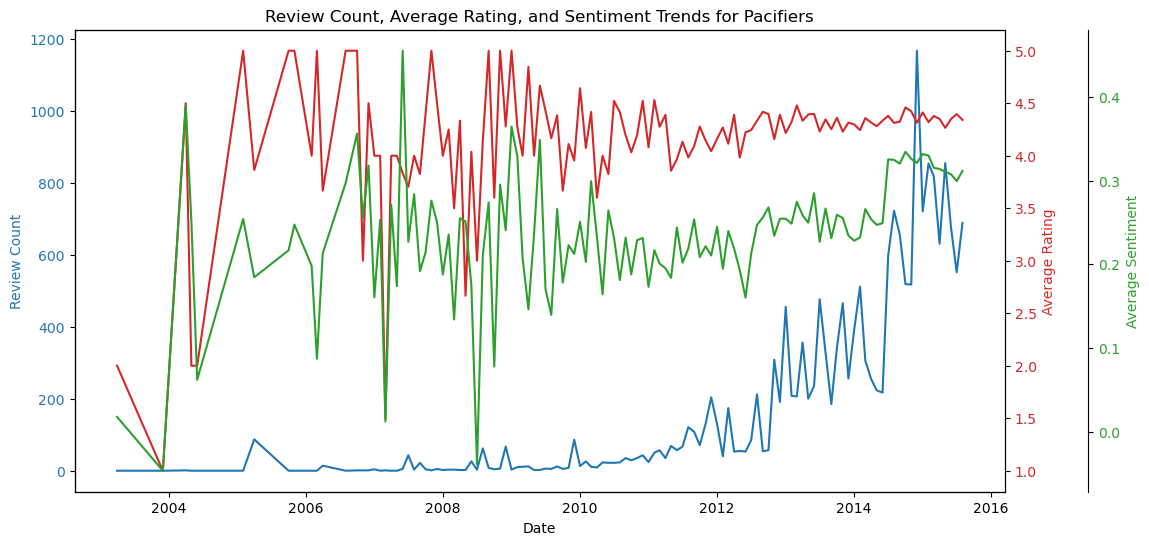

In [8]:
analyze_trends(microwave_data, 'Microwaves')
analyze_trends(hair_dryer_data, 'Hair Dryers')
analyze_trends(pacifier_data, 'Pacifiers')

In [9]:
# Function to fit and forecast using ARIMA model
def forecast_arima_Rating(rating_series, periods=12):
    # Automatically fitting a model
    model = auto_arima(rating_series, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)
    print(model.summary())  # Check the model summary to understand the fit
    
    # Forecast
    forecast = model.predict(n_periods=periods)
    return forecast


In [10]:
# Function to fit and forecast using ARIMA model
def forecast_arima_Sentiment(rating_series, periods=12):
    # Automatically fitting a model
    model = auto_arima(rating_series, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=12,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)
    print(model.summary())  # Check the model summary to understand the fit
    
    # Forecast
    forecast = model.predict(n_periods=periods)
    return forecast

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=321.526, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=311.996, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=313.679, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=295.304, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=288.496, Time=0.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=294.733, Time=0.25 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=276.055, Time=0.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=281.293, Time=0.13 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=278.053, Time=

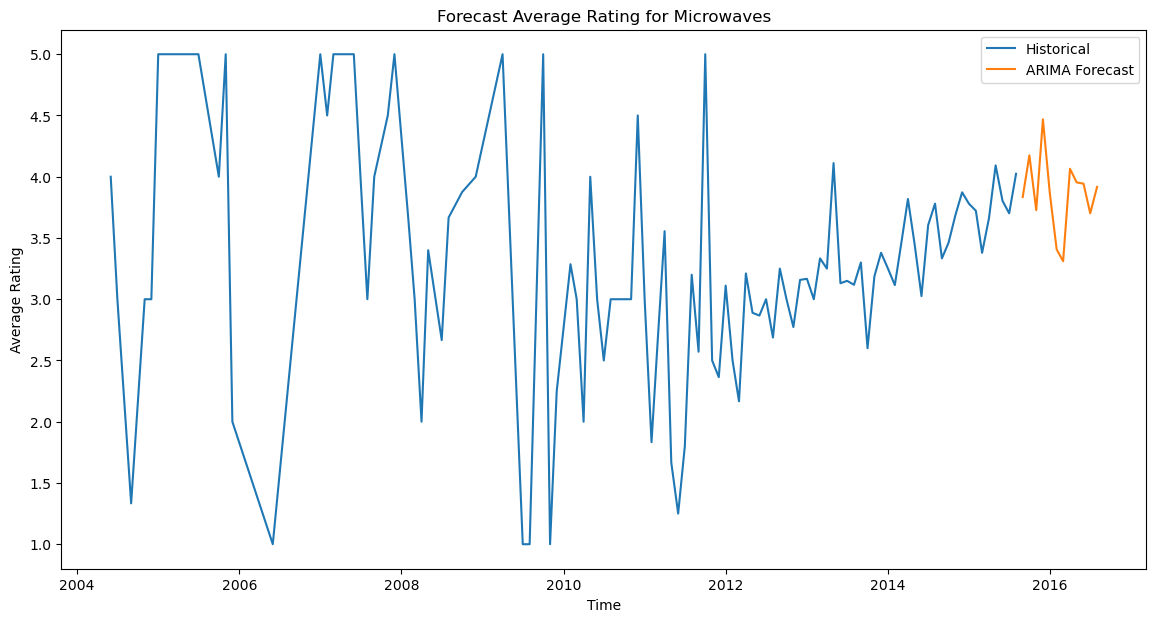

In [11]:
def analyze_and_forecast_Rating(grouped_data, title):
    # Forecast using ARIMA
    future_periods = 12  # For next year with monthly data
    rating_series = grouped_data['average_rating']
    arima_forecast = forecast_arima_Rating(rating_series, periods=future_periods)

    # Plot forecasts
    plt.figure(figsize=(14, 7))
    plt.plot(grouped_data['review_date'], grouped_data['average_rating'], label='Historical')
    plt.plot(pd.date_range(grouped_data['review_date'].iloc[-1], periods=future_periods, freq='M'), arima_forecast, label='ARIMA Forecast')
    plt.title(f'Forecast Average Rating for {title}')
    plt.xlabel('Time')
    plt.ylabel('Average Rating')
    plt.legend()
    plt.show()


def analyze_and_forecast_Sentiment(grouped_data, title):
    # Forecast using ARIMA
    future_periods = 12  # For next year with monthly data
    sentiment_series = grouped_data['average_sentiment']
    arima_forecast = forecast_arima_Sentiment(sentiment_series, periods=future_periods)

    # Plot forecasts
    plt.figure(figsize=(14, 7))
    plt.plot(grouped_data['review_date'], grouped_data['average_sentiment'], label='Historical')
    plt.plot(pd.date_range(grouped_data['review_date'].iloc[-1], periods=future_periods, freq='M'), arima_forecast, label='ARIMA Forecast')
    plt.title(f'Forecast Average Sentiment for {title}')
    plt.xlabel('Time')
    plt.ylabel('Average Sentiment')
    plt.legend()
    plt.show()
    

analyze_and_forecast_Rating(microwave_data, 'Microwaves')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-75.606, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-8.934, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-36.455, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-77.519, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-46.691, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-75.545, Time=0.28 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-69.007, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-73.579, Time=0.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-30.491, Time=0.07 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-75.619, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-47.954, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-73.998, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.44 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]     

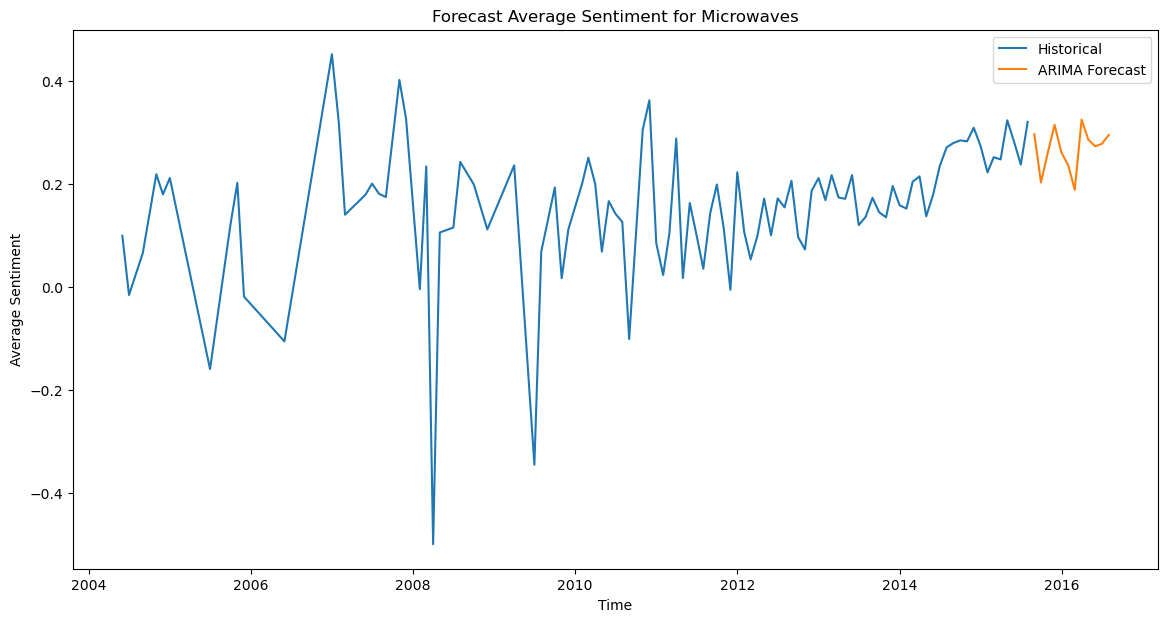

In [12]:
analyze_and_forecast_Sentiment(microwave_data, 'Microwaves')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=346.747, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=325.931, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=297.534, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=316.846, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=296.702, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=306.295, Time=0.04 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=296.235, Time=0.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=300.195, Time=0.16 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=297.958, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=297.428, Time=0.97 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=332.522, Time=0.49 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=31

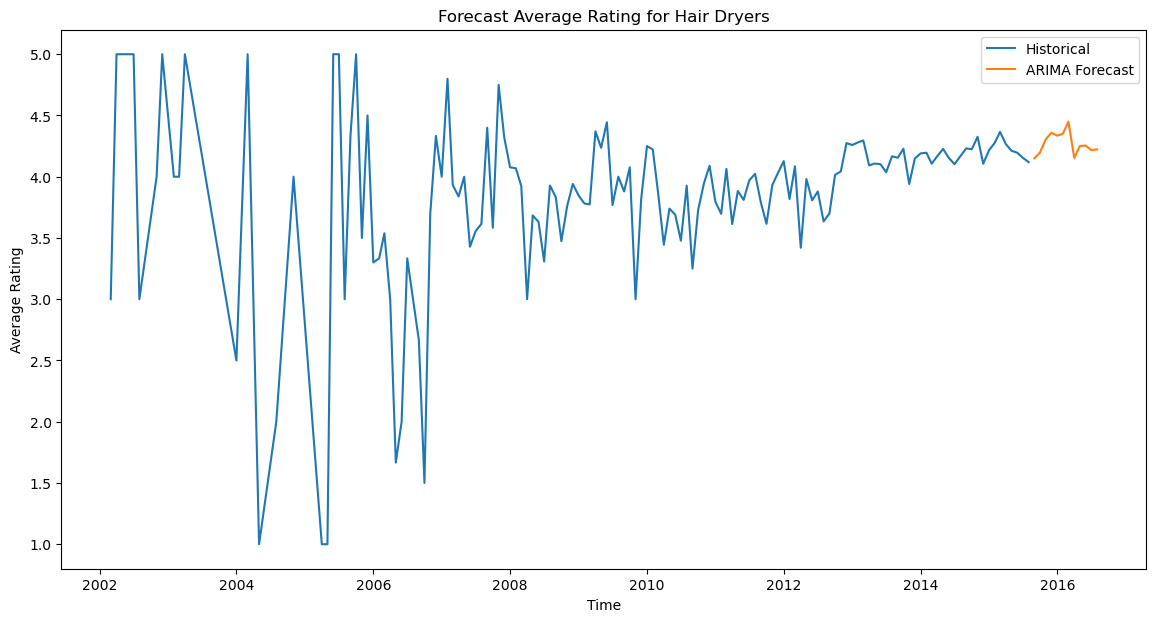

In [13]:
analyze_and_forecast_Rating(hair_dryer_data, 'Hair Dryers')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-116.541, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-219.305, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-190.216, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-241.467, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-248.194, Time=1.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=-246.910, Time=1.17 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-199.370, Time=1.02 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-258.387, Time=1.70 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-246.3

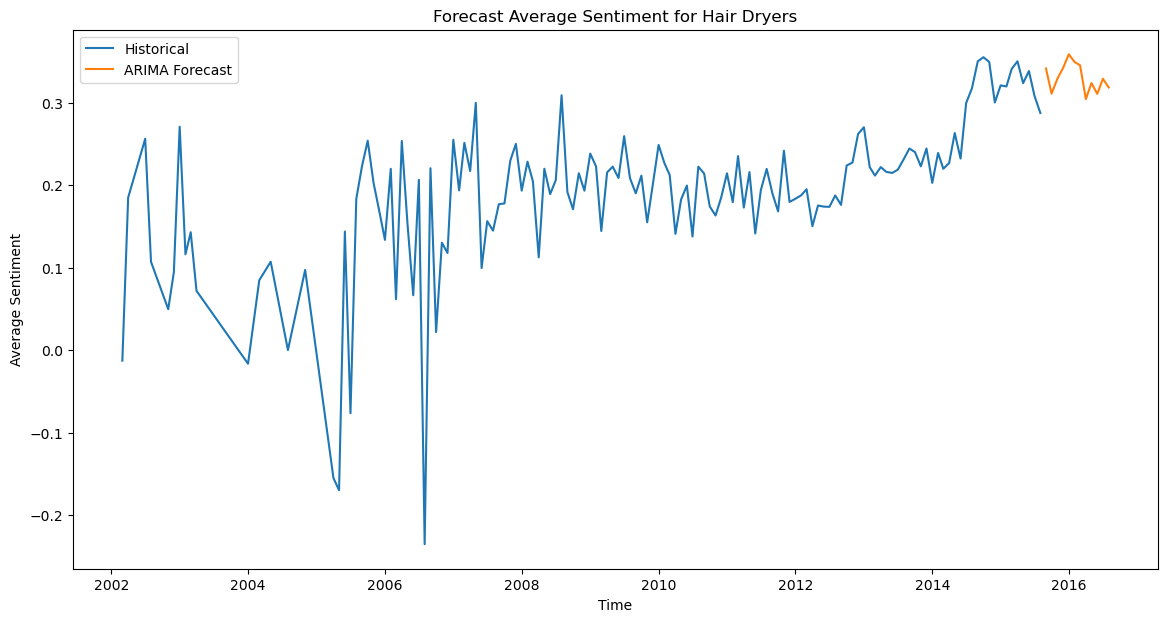

In [14]:
analyze_and_forecast_Sentiment(hair_dryer_data, 'Hair Dryers')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=317.139, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=256.990, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=289.853, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=250.054, Time=0.28 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=248.485, Time=0.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=246.494, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=248.487, Time=0.53 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=246.849, Time=0.22 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=250.347, Time=0.70 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=289.919, Time=0.10 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=233.684, Time=0.19 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=in

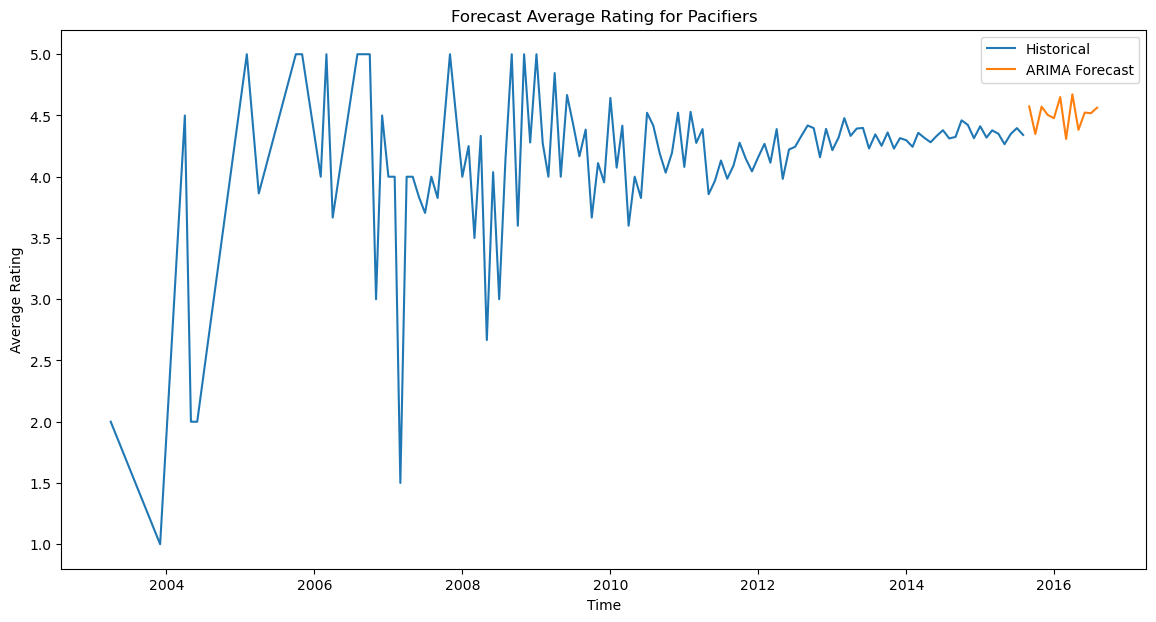

In [15]:
analyze_and_forecast_Rating(pacifier_data, 'Pacifiers')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-228.383, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-153.159, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-200.012, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-229.574, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-190.903, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-229.982, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-222.807, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-228.001, Time=0.75 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-227.998, Time=0.97 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-229.889, Time=0.76 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-228.215, Time=0.32 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-225.987, Time=1.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-181.308, Time=0.15 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-228.373, Time=0.47 sec
 ARIMA(0,1,2)(1,1,1

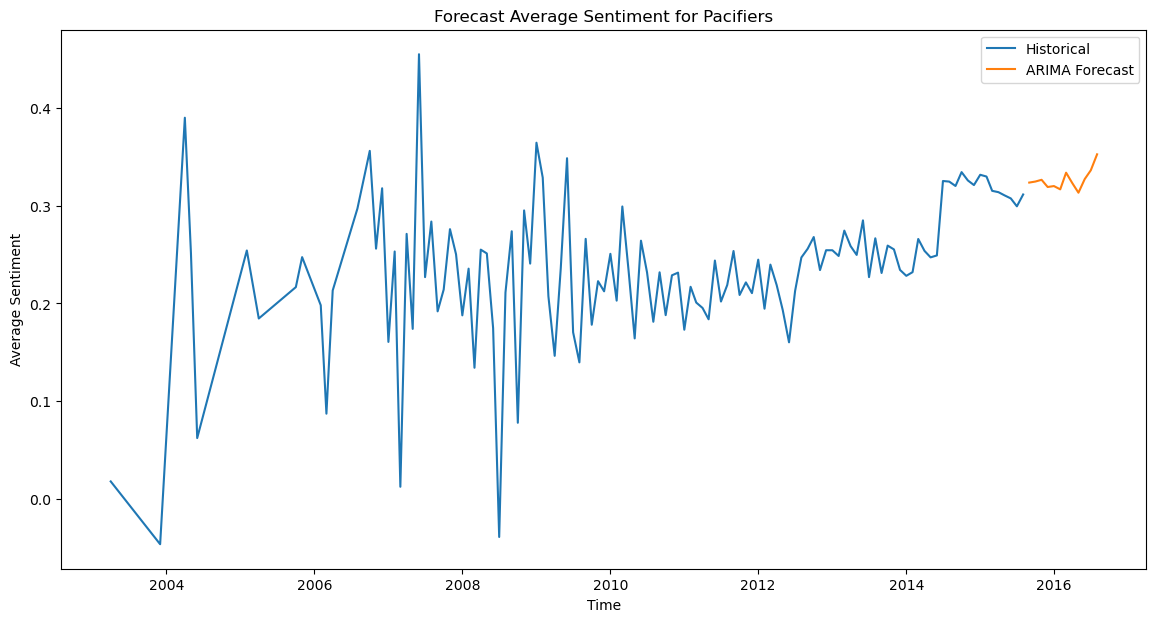

In [16]:
analyze_and_forecast_Sentiment(pacifier_data, 'Pacifiers')

In [27]:
def filtered_data(data):
    data = data[data['review_date'] >= '2010-01-01']
    return data

In [28]:
microwave_data = filtered_data(microwave_data)
hair_dryer_data = filtered_data(hair_dryer_data)
pacifier_data = filtered_data(pacifier_data)

In [29]:
microwave_data.head()

,review_date,review_count,average_rating,average_sentiment
34,2010-02-01,7,3.285714,0.199854
35,2010-03-01,4,3.000000,0.250211
36,2010-04-01,4,2.000000,0.199220
37,2010-05-01,1,4.000000,0.067857
38,2010-06-01,1,3.000000,0.165915


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=129.609, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=165.429, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=150.118, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=127.836, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=140.004, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=129.822, Time=0.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=132.505, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=152.070, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=129.508, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=130.934, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
T

/Users/rattanansiritaworachan/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


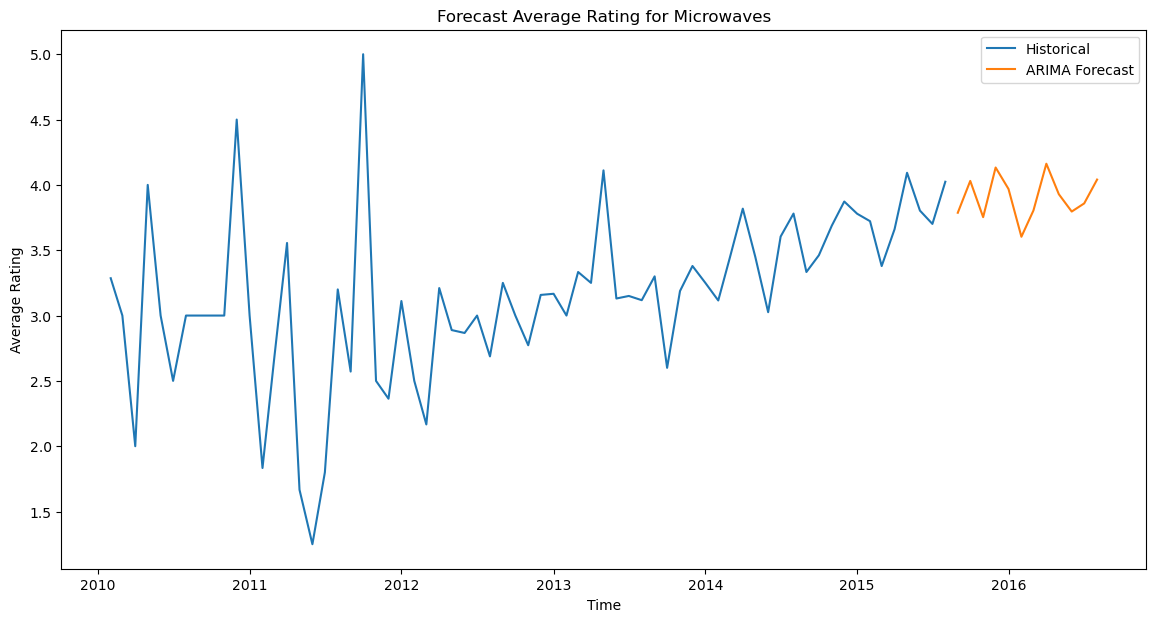

In [30]:
analyze_and_forecast_Rating(microwave_data, 'Microwaves')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-43.401, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-63.814, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-48.908, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-67.742, Time=0.28 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-66.733, Time=0.47 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-68.349, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-68.878, Time=0.99 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-64.866, Time=0.42 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-82.324, Time=0.50 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=-80.406, T

/Users/rattanansiritaworachan/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


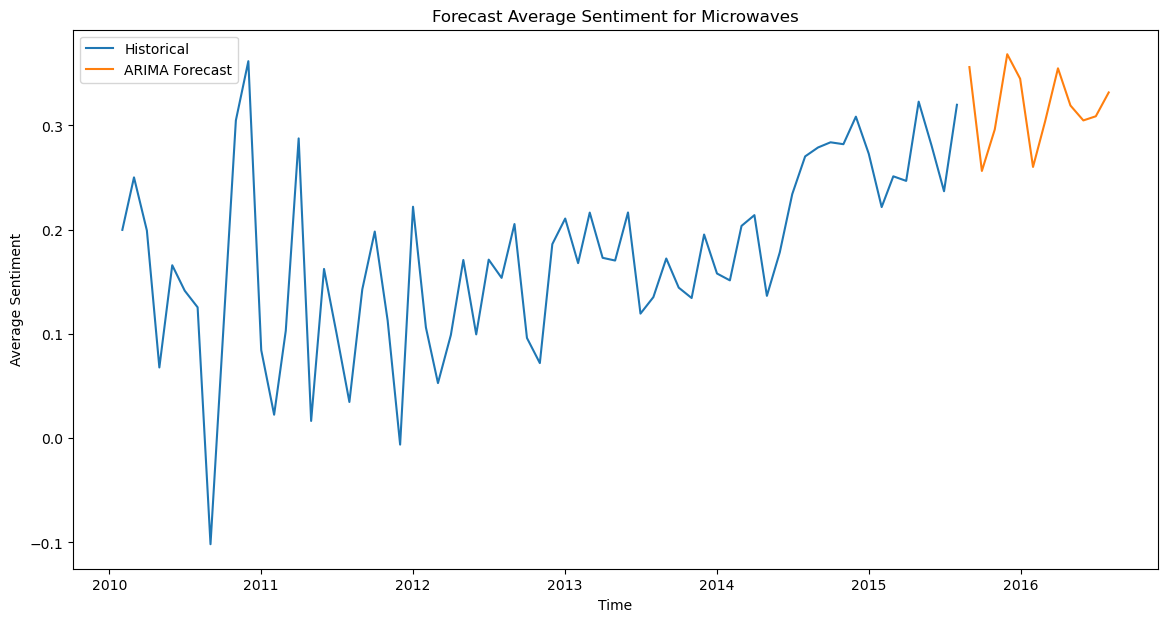

In [31]:
analyze_and_forecast_Sentiment(microwave_data, 'Microwaves')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12.598, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-5.926, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-8.613, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-0.404, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-7.101, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-7.313, Time=0.20 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-7.778, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=8.472, Time=0.16 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-6.903, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-5.226, Time=0.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-6.123, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-6.814, Time=0.23 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total 

/Users/rattanansiritaworachan/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


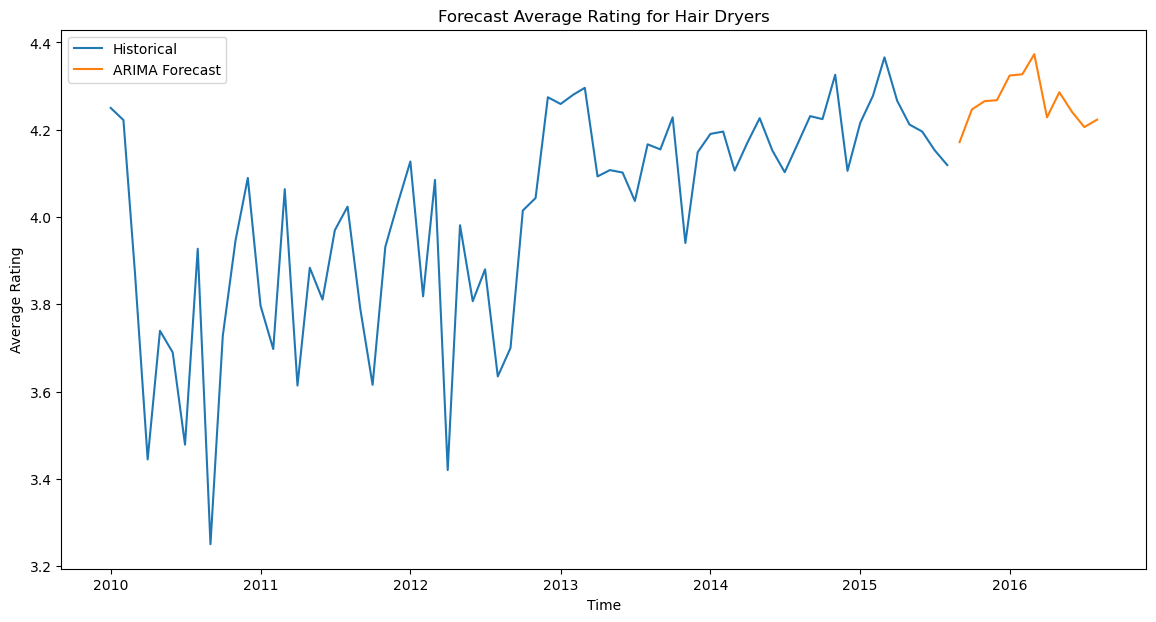

In [32]:
analyze_and_forecast_Rating(hair_dryer_data, 'Hair Dryers')

In [ ]:
analyze_and_forecast_Sentiment(hair_dryer_data, 'Hair Dryers')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-197.722, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-172.364, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-194.873, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-199.653, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-185.231, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-198.876, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-200.289, Time=0.56 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-189.816, Time=0.40 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=-198.385, Time=0.55 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-198.391, Time=0.88 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=-196.319, Time=0.94 sec


In [ ]:
analyze_and_forecast_Rating(pacifier_data, 'Pacifiers')

In [ ]:
analyze_and_forecast_Sentiment(pacifier_data, 'Pacifiers')